In [18]:
# coding: utf-8
import sys
from tqdm import tqdm 
import numpy as np
from skimage.transform import resize
from numpy.fft import fftn, fftshift

import matplotlib.pyplot as plt

import os

from matplotlib import colors
import matplotlib.pyplot as plt

# from cupyx.scipy.signal import convolve2d as conv2
# import cupy as cp

# from scipy.signal import convolve2d as conv2np
import random

from multiprocessing import Pool, get_context
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from joblib import Parallel, delayed

from pathlib import Path

import h5py

import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../'))) #add deconvolutionNN directory to path in order to import other files
from src.utils.preprocessing_functions import *
plt.rcParams["image.cmap"] = "jet"

In [59]:
def create_waxs_mask(image_shape, box_size):
    """
    Create a mask to isolate the WAXS (frame-like) region.
    Args:
        image_shape (tuple): Shape of the input image (H, W).
        box_size (int): Size of the central box to exclude.
    Returns:
        Tensor: Mask with 1s in the WAXS region and 0s in the central box.
    """
    h, w = image_shape
    mask = torch.ones((h, w), dtype=torch.float32)
    cx, cy = w // 2, h // 2  # Center coordinates
    half_box = box_size // 2
    mask[cy - half_box:cy + half_box, cx - half_box:cx + half_box] = 0  # Exclude center box
    return mask

def apply_waxs_mask(image, mask):
    """
    Apply the WAXS mask to isolate the outer region.
    Args:
        image (Tensor): Input image tensor [B, C, H, W].
        mask (Tensor): WAXS mask [H, W].
    Returns:
        Tensor: Image with only the WAXS region retained.
    """
    return image * mask.unsqueeze(0).unsqueeze(0) 
    
def create_circular_waxs_mask(image_shape, radius):
    """
    Create a circular mask for the WAXS region.
    Args:
        image_shape (tuple): Shape of the input image (H, W).
        radius (int): Radius of the central circular region to exclude.
    Returns:
        Tensor: Circular mask with 1s in the WAXS region and 0s in the central circle.
    """
    h, w = image_shape
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
    center_y, center_x = h // 2, w // 2  # Center coordinates
    distance_from_center = torch.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    mask = (distance_from_center > radius).float()  # 1 outside the circle, 0 inside
    return mask

def create_circular_waxs_mask2(image, radius):
    """
    Create a circular mask for the WAXS region that sets the central region to the minimum value.
    
    Args:
        image (Tensor or ndarray): Input image to be masked.
        radius (int): Radius of the central circular region to modify.
        
    Returns:
        Same type as input: Image with central circle set to minimum value.
    """
    # Handle both numpy arrays and PyTorch tensors
    is_tensor = isinstance(image, torch.Tensor)
    
    if is_tensor:
        h, w = image.shape[-2:]
        y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing="ij")
        center_y, center_x = h // 2, w // 2
        distance_from_center = torch.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
        
        # Find minimum value in the image
        min_val = torch.min(image)
        
        # Create a copy of the image
        masked_image = image.clone()
        
        # Set central region to minimum value
        mask = (distance_from_center <= radius)
        if len(image.shape) > 2:  # Handle batched images
            # Expand mask dimensions to match image
            for _ in range(len(image.shape) - 2):
                mask = mask.unsqueeze(0)
            # Apply to all channels/batches
            masked_image = torch.where(mask, min_val, image)
        else:
            masked_image[mask] = min_val
            
    else:  # Numpy array
        h, w = image.shape[-2:]
        y, x = np.indices((h, w))
        center_y, center_x = h // 2, w // 2
        distance_from_center = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
        
        # Find minimum value in the image
        min_val = np.min(image)
        
        # Create a copy of the image
        masked_image = image.copy()
        
        # Set central region to minimum value
        mask = (distance_from_center <= radius)
        if len(image.shape) > 2:  # Handle batched images
            # Expand mask dimensions to match image
            for _ in range(len(image.shape) - 2):
                mask = np.expand_dims(mask, axis=0)
            # Apply to all channels/batches
            masked_image = np.where(mask, min_val, image)
        else:
            masked_image[mask] = min_val
    
    return masked_image

In [13]:
#reduce size of diffraction patterns
red=False #True

#save processed data
save=False

# Setting path
path = Path("Y:/ptychosaxs")  # /net/micdata/data2/12IDC mounted windows drive
path = Path("/net/micdata/data2/12IDC/ptychosaxs")  # /net/micdata/data2/12IDC mounted windows drive
print(path)

/net/micdata/data2/12IDC/ptychosaxs


In [7]:
# Parameters
num = 30  # Dataset number
max_dps = 5000  # Maximum number of diffraction patterns to include

# Define the base path
base_path = Path('/net/micdata/data2/12IDC/ptychosaxs')
data_location = base_path / f'data/diff_sim/{num}/'
print(f"Reading data from: {data_location}")

# Generate the specific filenames with the required pattern
filenames = []
for numdps in range(1, max_dps + 1):
    filename = f"output_hanning_conv_{numdps:05d}.npz"
    file_path = data_location / filename
    if file_path.exists():
        filenames.append(file_path)
    else:
        # Stop if we can't find the next file (optional)
        # break
        pass

print(f"Found {len(filenames)} files matching the pattern")

# Combine into HDF5 (if not already done so)
output_file = base_path / f"data/combined_data_{num}.h5"
if output_file.exists():
    print(f'Combined file {output_file} already exists')
else:
    print('Loading and writing to h5...')
    with h5py.File(output_file, "w") as h5f:
        for i, file_path in tqdm(enumerate(filenames)):
            data = np.load(file_path)
            h5f.create_dataset(f"convDP_{i}", data=data["convDP"])
            h5f.create_dataset(f"pinholeDP_{i}", data=data["pinholeDP"])
    
    print(f"Successfully created {output_file} with {len(filenames)} diffraction patterns")

Reading data from: /net/micdata/data2/12IDC/ptychosaxs/data/diff_sim/30
Found 5000 files matching the pattern
Loading and writing to h5...


5000it [05:51, 14.21it/s]


Successfully created /net/micdata/data2/12IDC/ptychosaxs/data/combined_data_30.h5 with 5000 diffraction patterns


In [8]:
#load convoluted and ideal diffraction patterns
print('Loading data...')
# Load data with progress bar
with h5py.File(output_file, "r") as h5f:
    # Get the keys (dataset names)
    dataset_keys = list(h5f.keys()) 
    num_datasets = len(dataset_keys) // 2  # Assuming convDP and pinholeDP pairs
    print(f'{num_datasets} diffraction patterns')
    # Initialize empty lists for the data
    conv_DPs = []
    pinhole_DPs = []

    # Number of diffration patterns
    numDPs = 5000#10000
    
    # Use tqdm for progress tracking
    for i in tqdm(range(num_datasets)[:numDPs], desc="Loading HDF5 datasets"):
        conv_DPs.append(h5f[f"convDP_{i}"][:])  # Load convDP dataset
        pinhole_DPs.append(h5f[f"pinholeDP_{i}"][:])  # Load pinholeDP dataset

# convert to np arrays
conv_DPs=np.asarray(conv_DPs)
ideal_DPs=np.asarray(pinhole_DPs)
probe_DPs=np.ones(conv_DPs.shape) #dummy array for testing network with a probe

Loading data...
5000 diffraction patterns


Loading HDF5 datasets:   0%|          | 0/5000 [00:00<?, ?it/s]

Loading HDF5 datasets: 100%|██████████| 5000/5000 [01:07<00:00, 74.51it/s]


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:06<00:00, 721.21it/s]


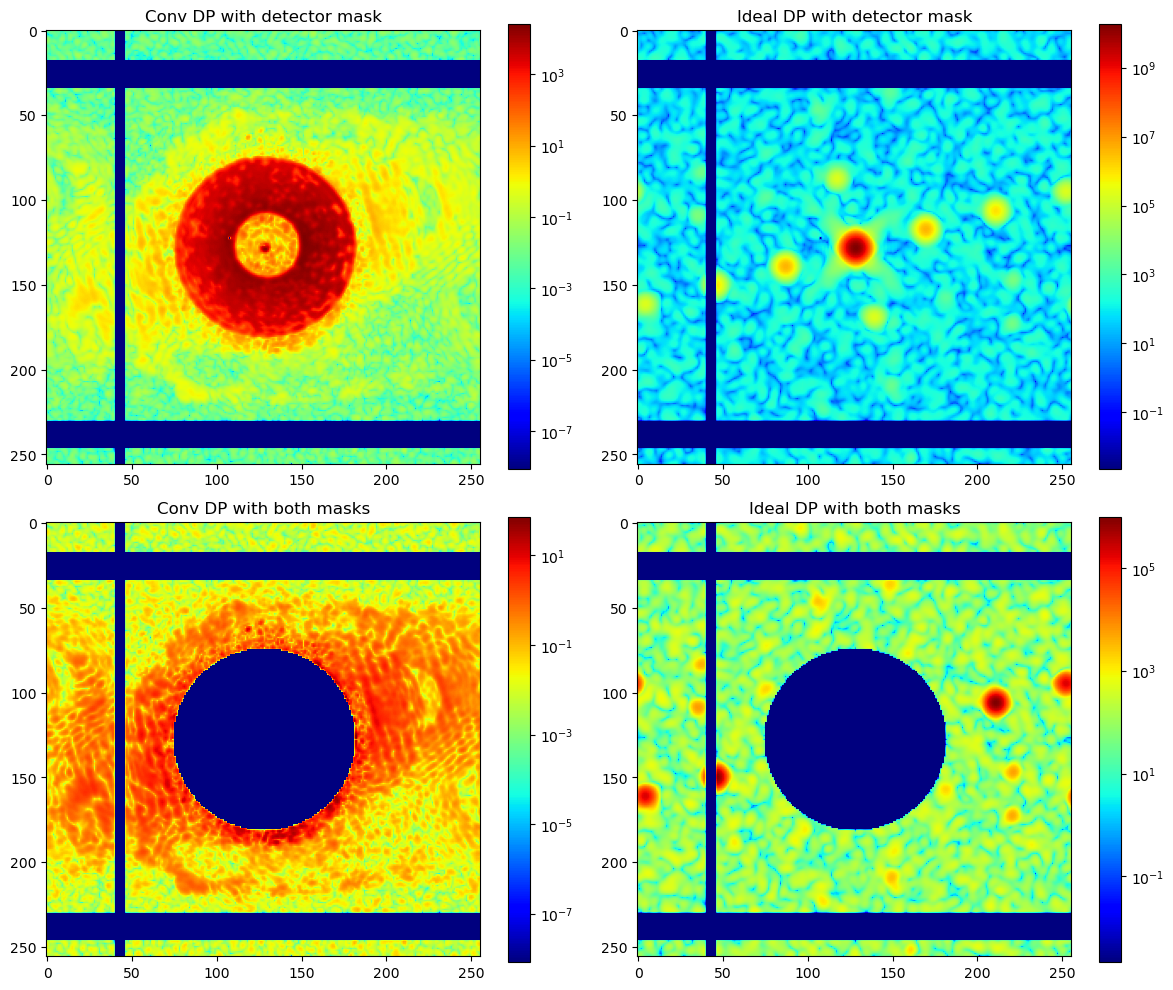

In [70]:
def create_circular_waxs_mask_min_value(image, radius):
    """
    Create a modified version of the image where the central region is set to the minimum value.
    
    Args:
        image (ndarray): Input image to be masked
        radius (int): Radius of the central circular region to modify
        
    Returns:
        ndarray: Image with central circle set to minimum value
    """
    # Create a copy of the image
    masked_image = image.copy()
    
    # Find minimum value in the image (excluding zeros or NaNs if needed)
    valid_pixels = image[image > 0]  # Adjust if needed
    if len(valid_pixels) > 0:
        min_val = np.min(valid_pixels)
    else:
        min_val = 0
    
    # Create the circular mask
    h, w = image.shape
    y, x = np.indices((h, w))
    center_y, center_x = h // 2, w // 2
    distance_from_center = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    
    # Set central region to minimum value
    central_region = (distance_from_center <= radius)
    masked_image[central_region] = min_val
    
    return masked_image

# Load your detector mask as before
detector_mask = np.load(os.path.abspath(os.path.join(os.getcwd(), '../../data/mask/mask_ZCB_9_3D.npy')))

# Apply both masks to each image
processed_conv_DPs = []
processed_ideal_DPs = []

# Define the radius for the WAXS mask
radius = 54

# Process each image
for i in tqdm(range(len(conv_DPs))):
    # First apply the detector mask
    masked_conv = apply_mask(conv_DPs[i], detector_mask)
    masked_ideal = apply_mask(ideal_DPs[i], detector_mask)
    
    # Then apply the WAXS mask that sets central region to minimum
    processed_conv = create_circular_waxs_mask_min_value(masked_conv, radius)
    processed_ideal = create_circular_waxs_mask_min_value(masked_ideal, radius)
    
    processed_conv_DPs.append(processed_conv)
    processed_ideal_DPs.append(processed_ideal)

# Convert to numpy arrays
processed_conv_DPs = np.array(processed_conv_DPs)
processed_ideal_DPs = np.array(processed_ideal_DPs)

# Visualize the results
ri = np.random.randint(0, len(processed_conv_DPs))
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Original images with detector mask
im1 = ax[0, 0].imshow(masked_conv, cmap="jet", norm=colors.LogNorm())
ax[0, 0].set_title("Conv DP with detector mask")
plt.colorbar(im1, ax=ax[0, 0])

im2 = ax[0, 1].imshow(masked_ideal, cmap="jet", norm=colors.LogNorm())
ax[0, 1].set_title("Ideal DP with detector mask")
plt.colorbar(im2, ax=ax[0, 1])

# Images with both masks
im3 = ax[1, 0].imshow(processed_conv_DPs[-1], cmap="jet", norm=colors.LogNorm())
ax[1, 0].set_title("Conv DP with both masks")
plt.colorbar(im3, ax=ax[1, 0])

im4 = ax[1, 1].imshow(processed_ideal_DPs[-1], cmap="jet", norm=colors.LogNorm())
ax[1, 1].set_title("Ideal DP with both masks")
plt.colorbar(im4, ax=ax[1, 1])

plt.tight_layout()
plt.show()

100%|██████████| 5000/5000 [00:04<00:00, 1105.03it/s]


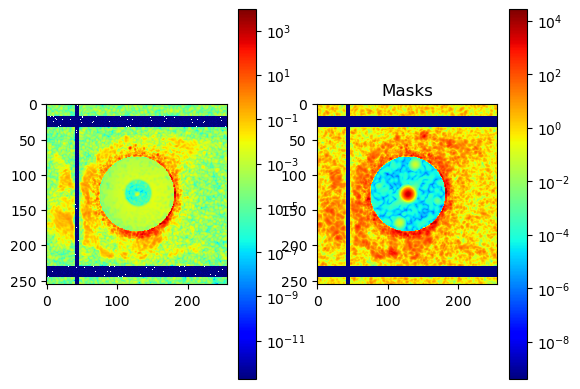

In [66]:
# # Deal with detector mask
# # upper and lower bar bounds for diffraction panels

# # chansong
# # conv_DPs_masked=np.asarray([apply_mask(conv_DPs[i],np.load(os.path.abspath(os.path.join(os.getcwd(), '../../data/mask/mask_Chansong256x256Cropped.npy')))) for i in range(0,len(conv_DPs))])
# # cindy
# # conv_DPs_masked=np.asarray([apply_mask(conv_DPs[i],np.load(os.path.abspath(os.path.join(os.getcwd(), '../../data/mask/mask_CindyPtychoshelvesHDF5preprocessed.npy')))) for i in range(0,len(conv_DPs))])
# # ZCB_9_3D
# conv_DPs_masked=np.asarray([apply_mask(conv_DPs[i],np.load(os.path.abspath(os.path.join(os.getcwd(), '../../data/mask/mask_ZCB_9_3D.npy')))) for i in tqdm(range(0,len(conv_DPs)))])
# ideal_DPs_masked=np.asarray([apply_mask(ideal_DPs[i],np.load(os.path.abspath(os.path.join(os.getcwd(), '../../data/mask/mask_ZCB_9_3D.npy')))) for i in tqdm(range(0,len(conv_DPs)))])


# #create WAXS mask
# h, w = 256,256
# radius = 54#58 #160*2
# waxs_mask = create_circular_waxs_mask2(conv_DPs_masked[0], radius)
# fig,ax=plt.subplots(1,2)
# im1=ax[0].imshow(conv_DPs_masked[0]*waxs_mask,cmap="jet",norm=colors.LogNorm())
# im2=ax[1].imshow(ideal_DPs_masked[0]*waxs_mask,cmap="jet",norm=colors.LogNorm())
# plt.colorbar(im1)
# plt.colorbar(im2)
# plt.title("Masks")
# plt.show()


# conv_DPs_masked=np.asarray([conv_DPs_masked[i]*waxs_mask for i in tqdm(range(0,len(conv_DPs_masked)))])
# ideal_DPs_masked=np.asarray([ideal_DPs_masked[i]*waxs_mask for i in tqdm(range(0,len(ideal_DPs_masked)))])


# with h5py.File('/net/micdata/data2/12IDC/2025_Feb/ptycho/5045/ZCB_9_3D_5045_00004_00032.h5', "r") as h5f:
#     print(h5f['entry']['data']['data'][()].shape)
#     center=(517,575)
#     dp=h5f['entry']['data']['data'][()][center[0]-128:center[0]+128,center[1]-128:center[1]+128]
#     mask = np.where(dp < 0, 0, 1)  # Create binary mask: 0 where dp<=0, 1 elsewhere
    
#     fig,ax=plt.subplots(1,3)
#     im1=ax[0].imshow(dp,norm=colors.LogNorm())
#     im2=ax[1].imshow(mask)  # No need for LogNorm since mask is binary
#     im3=ax[2].imshow(dp*mask,norm=colors.LogNorm())
#     plt.colorbar(im1)
#     plt.colorbar(im2)
#     plt.colorbar(im3)
#     plt.show()


In [62]:
#shuffle data correspondingly
indices = np.arange(conv_DPs_masked.shape[0])
np.random.shuffle(indices)
conv_DPs_shuff = conv_DPs_masked[indices]
ideal_DPs_shuff = ideal_DPs_masked[indices]
probe_DPs_shuff=probe_DPs[indices]

In [63]:
# separate amplitude and phase
# thus network used the amplitude of the intensity patterns
amp_conv = log10_custom(conv_DPs_shuff)
amp_ideal = log10_custom(ideal_DPs_shuff)
amp_probe = np.abs(probe_DPs_shuff)
phase_conv = np.angle(conv_DPs_shuff)
phase_ideal = np.angle(ideal_DPs_shuff)
phase_probe = np.angle(probe_DPs_shuff)

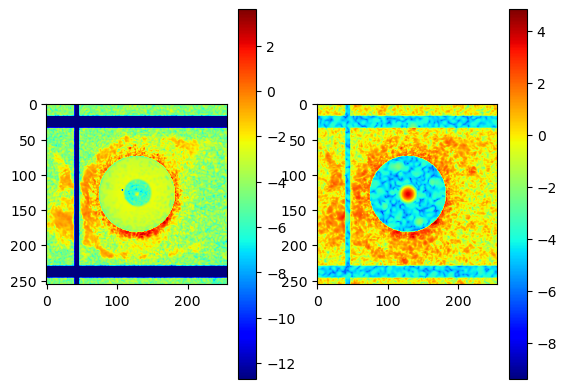

In [64]:
# plot random diffraction pattern
fig,ax=plt.subplots(1,2)
ri=random.randint(0,len(amp_conv))
im1=ax[0].imshow(amp_conv[ri])
im2=ax[1].imshow(amp_ideal[ri])
plt.colorbar(im1)
plt.colorbar(im2)
plt.show()

In [15]:
# resize data
if red:
    print("Resizing...")
    amp_ideal_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(amp_ideal)])
    amp_conv_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(amp_conv)])
    amp_probe_red=np.asarray([resize(d[:,:],(256,256),preserve_range=True,anti_aliasing=True) for d in tqdm(amp_probe)])
else:
    print("No resizing...")
    amp_ideal_red=amp_ideal
    amp_conv_red=amp_conv
    amp_probe_red=amp_probe
print(f'maximum in ideal patterns: {np.max(amp_ideal_red[ri])}')
print(f'maximum in conv patterns: {np.max(amp_conv_red[ri])}')    

No resizing...
maximum in ideal patterns: 10.098760470495607
maximum in conv patterns: 4.214632930620199


/tmp/ipykernel_3360454/2302143922.py:16: RuntimeWarning: invalid value encountered in divide
  amp_probe_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_probe_red])


normalized maximum in ideal/output patterns: 1.0
normalized maximum in conv/input patterns: 1.0


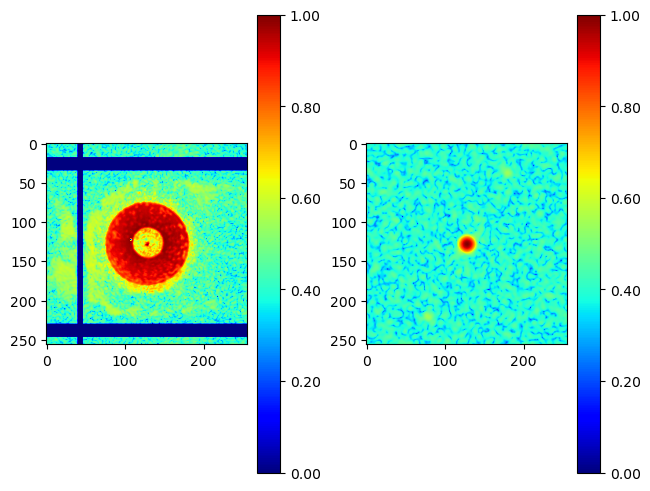

In [16]:
# Scale factors

#NORMALIZE OUTPUT FROM 0 to 1
ideal_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in amp_ideal_red])
ideal_constants=np.asarray([(np.min(a)) for a in amp_ideal_red])
amp_ideal_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_ideal_red])

# #NORMALIZE INPUT FROM 0 to 1
conv_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in amp_conv_red])
conv_constants=np.asarray([(np.min(a)) for a in amp_conv_red])
amp_conv_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_conv_red])

# #NORMALIZE INPUT FROM 0 to 1
probe_scale_factors=np.asarray([(np.max(a)-np.min(a)) for a in amp_probe_red])
probe_constants=np.asarray([(np.min(a)) for a in amp_probe_red])
amp_probe_red=np.asarray([(a-np.min(a))/(np.max(a)-np.min(a)) for a in amp_probe_red])

print(f'normalized maximum in ideal/output patterns: {np.max(amp_ideal_red[0])}')
print(f'normalized maximum in conv/input patterns: {np.max(amp_conv_red[0])}')

fig,ax=plt.subplots(1,2,layout='constrained')
im1=ax[1].imshow(amp_ideal_red[0])#,norm=colors.LogNorm())
plt.colorbar(im1, ax=ax[1], format='%.2f')
im2=ax[0].imshow(amp_conv_red[0])#,norm=colors.LogNorm())
plt.colorbar(im2, ax=ax[0], format='%.2f')
plt.show()

In [17]:
save=True
if save:
    np.savez(os.path.abspath(os.path.join(os.getcwd(), f'../../data/processed/preprocessed_dir{num}_numDPs{numDPs}.npz')),amp_conv_red=amp_conv_red,amp_ideal_red=amp_ideal_red,amp_probe_red=amp_probe_red)